# Lab-3: Logistic Regression
_____
##### In this lab, you will apply Logistic Regression to predict survival on Titanic and learn to analyze classification results.

### Objectives:
1. Visualize LogReg basics
2. Split unbalanced data
3. Apply Logistic regression
4. Analyze results (Confusion Matrix, Precision, Recall)
-----

### Concepts Visualization

Here are main equations behind Logistic Regression:

$\hat p(x) = \frac{1}{1+e^{-(\beta_0 + \beta_1 x)}}$

$L(\hat{p}(x_i), y_i) = -y_i\log (\hat{p}(x_i)) - (1 - y)_i\log (1 -\hat{p}(x_i))$

$L(\hat{p}(x_i), y_i) = \left \\{\begin{matrix}
\ - log (\hat{p}(x_i)), & y_i=1\\ 
\ - log (1 -\hat{p}(x_i)), & y_i=0
\end{matrix}\right.$

$\hat{y} = \left\\{\begin{matrix}
1 && \hat p(x) > threshold\\ 
0 && otherwise 
\end{matrix}\right.$


<br>

1. What problem does Logistic Regression solve?
2. What is the output of Logistic Regression model?
2. Why can't we use average MSE as a loss function (as we did in Linear Regression)?
3. How can we adapt Logistic Regression to solve a multiclass problem?

<br>
Let's now see how the shape of

$\hat p(x)$
depends on its parameters:

In [190]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

#### Task: Implement the sigmoid function using numpy lib.

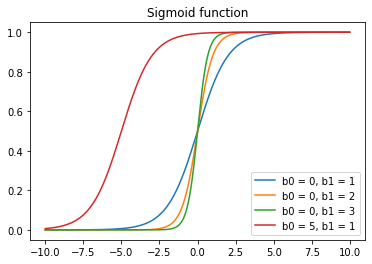

In [191]:
x = np.arange(-10, 10, 0.01)

def plot(b0, b1):
    # Edit the next line to implement the probability formulation.
    p = 1 / (1 + np.exp(-(b0 + b1 * x)))
    label = "b0 = {}, b1 = {}".format(b0, b1)
    plt.plot(x, p, label=label)

plot(0,1)
plot(0,2)
plot(0,3)
plot(5,1)
plt.legend()
plt.title('Sigmoid function')
plt.show()

What is controlled by parameters b0, b1?  
<br><br> 
Let's now visualize the components of the Loss function:

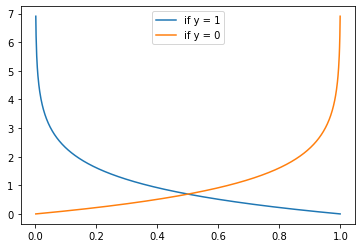

In [192]:
x = np.arange(0.001, 1, 0.001)
y1 = -np.log(x)
y0 = -np.log(1-x)

plt.plot(x,y1, label="if y = 1")
plt.plot(x,y0, label="if y = 0")
plt.legend()
plt.show()

What are the benefits of using logarithms in the loss function?   <br><br>

### Loading Data

In [193]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [194]:
import pandas as pd
data = pd.read_csv('/gdrive/My Drive/Colab Notebooks/Innopolis/ML Fall 2020/Lab 3/titanic.csv')
data

,survived,pclass,name,sex,age,sibsp,parch,fare,embarked
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,211.3375,S
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,151.5500,S
2,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,151.5500,S
3,0,1,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,151.5500,S
4,0,1,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,151.5500,S
...,...,...,...,...,...,...,...,...,...
1304,0,3,"Zabour, Miss. Hileni",female,14.50,1,0,14.4542,C
1305,0,3,"Zabour, Miss. Thamine",female,NaN,1,0,14.4542,C
1306,0,3,"Zakarian, Mr. Mapriededer",male,26.50,0,0,7.2250,C
1307,0,3,"Zakarian, Mr. Ortin",male,27.00,0,0,7.2250,C


In [195]:
# removing name column
data = data.drop(['name'], axis = 1)

What do we know about the output class distribution? What percentage of people had survived? Is it important to have the same distribution in test and train sets? Why?

##### Task. Find and print the proporion of the positive (survived) class in the dataset, then split data to train and test sets preserving that proportion. Finally, as a check, calculate and print proportions in resulting sets.

In [196]:
from sklearn.model_selection import train_test_split

# find and print the proportion of positive samples in data
print('% of positive samples in whole data:', data[data['survived'] == 1]['survived'].count() / data['survived'].count())

# split data
y = data['survived']
X = data.drop(columns=['survived'])
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# find and print the proportion of positive samples in train and test sets, make sure they are approx same
print('% of positive samples in train set:', y_train[y_train == 1].count() / y_train.count())
print('% of positive samples in test set:', y_test[y_test == 1].count() / y_test.count())

% of positive samples in whole data: 0.3819709702062643
% of positive samples in train set: 0.38204393505253104
% of positive samples in test set: 0.3816793893129771


#### Data preprocessing

... is done for you! But you are free to change it if needed.

In [197]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

# imputing missing values
imputer = SimpleImputer(strategy='most_frequent')
imputer.fit(x_train)
x_train = pd.DataFrame(imputer.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(imputer.transform(x_test), columns=x_test.columns)

# one-hot-encode categorical features
def ohe_new_features(df, features_name, encoder):
    new_feats = encoder.transform(df[features_name])
    # create dataframe from encoded features with named columns
    new_cols = pd.DataFrame(new_feats, dtype=int, columns=encoder.get_feature_names(features_name))
    new_df = pd.concat([df, new_cols], axis=1)    
    new_df.drop(features_name, axis=1, inplace=True)
    return new_df

encoder = OneHotEncoder(sparse=False, drop='first')
f_names = ['sex', 'embarked']
encoder.fit(x_train[f_names])
x_train = ohe_new_features(x_train, f_names, encoder)
x_test = ohe_new_features(x_test, f_names, encoder)

# feature scaling
scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = pd.DataFrame(scaler.transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x_test.columns)

In [198]:
x_train

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S
0,1.0,0.336313,0.000,0.000000,0.015469,1.0,0.0,1.0
1,0.0,0.553027,0.000,0.000000,0.262527,0.0,0.0,0.0
2,1.0,0.322769,0.000,0.000000,0.015094,1.0,1.0,0.0
3,1.0,0.241501,0.000,0.000000,0.015176,0.0,0.0,1.0
4,0.5,0.390492,0.125,0.000000,0.040989,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...
1042,1.0,0.000000,0.125,0.222222,0.040160,0.0,0.0,1.0
1043,1.0,0.322769,0.000,0.000000,0.015713,1.0,0.0,1.0
1044,1.0,0.322769,0.000,0.000000,0.015094,0.0,1.0,0.0
1045,0.5,0.268590,0.000,0.000000,0.071731,0.0,0.0,1.0


### Logistic Regression

Now we are ready to see Logistic Regression in practice. 

#### Task. Fit Logistic Regression and output Accuracy, Precision, and Recall scores on test set.

In [199]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
# fit Logistic Regression
clf = LogisticRegression().fit(x_train, y_train)

y_pred = clf.predict(x_test)

# caclulate and print metrics
print(metrics.accuracy_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))
print(metrics.recall_score(y_test, y_pred))

0.7862595419847328
0.7619047619047619
0.64


What about Logistic Regression Coefficients? Can we interpret them?

In [200]:
print(*[a for a in zip(list(x_train.columns), clf.coef_[0])], sep='\n')

('pclass', -1.6987971599639504)
('age', -1.4488704912058648)
('sibsp', -1.6102850870387084)
('parch', -0.2655948710999914)
('fare', 0.32005314737234236)
('sex_male', -2.475084130693668)
('embarked_Q', -0.5080428835798881)
('embarked_S', -0.6008476228833519)


How can we choose a threshold of prediciton? Let's try different ones and see their effect on metrics.


#### Task:
#### Predict the probability using the logistic regression classifier object.
#### For each threshold thresh, give positive label 1 if the probability is greater that thresh and negative otherwise.
#### Calculate Accuracy, Precision, and Recall values for each of the given threshold values
#### Plot them on the same graph (threshold on x-axis and metric value on y-axis) with different colours and add legends, titles, and axes labels.

[]


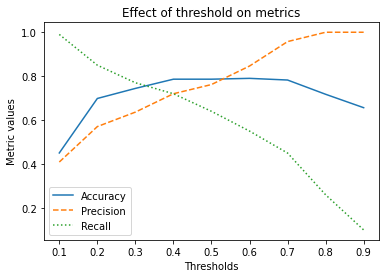

In [201]:
thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
# calculate metrics for each threshold above and plot the result as below.

metrics_results = [[], [], []]
print(metrics_results[0])
for thresh in thresholds:
    y_pred = ((clf.predict_proba(x_test) >= thresh).astype(int))[:,1]
    y_pred = y_pred.reshape(y_pred.size, 1)
    y_test_revised = (y_test.to_numpy().astype(int)).reshape(y_test.size, 1)
    # print(decisions.shape)
    # print(y_pred.shape)
    # print(((y_test.to_numpy().astype(int)).reshape(y_test.size, 1)).shape)
    accuracy = metrics.accuracy_score(y_test_revised, y_pred)
    recall = metrics.recall_score(y_test_revised, y_pred)
    precision = metrics.precision_score(y_test_revised, y_pred)
    # print('Accuracy: {:.2f}'.format(accuracy))
    # print(decisions)
    metrics_results[0].append(accuracy)
    metrics_results[1].append(precision)
    metrics_results[2].append(recall)
    pass
plt.plot(thresholds, metrics_results[0], '-',  label = 'Accuracy')
plt.plot(thresholds, metrics_results[1], '--', label = 'Precision')
plt.plot(thresholds, metrics_results[2], ':',  label = 'Recall')
plt.legend()
plt.title('Effect of threshold on metrics')
plt.xlabel('Thresholds')
plt.ylabel('Metric values')
plt.show()

### Confusion matrix

1. Why one may need confusion matrix? 
2. What new information does it show? 

<table><tr><td><img src='https://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix_files/confusion_matrix_1.png'></td><td><img src='http://wiki.fast.ai/images/6/61/Confusion_matrix.png' style='width: 400px;'></td></tr></table>

<img align='center' src='https://www.researchgate.net/profile/Emanuele_Principi/publication/324226324/figure/fig2/AS:612091408941056@1522945372985/Normalized-confusion-matrix-of-best-performing-models-on-devel-subset-a-SVM.png' style='width: 350px;'>


In [202]:
titanic_true_labels = np.array(y_test)
y_pred = clf.predict(x_test)
titanic_pred_labels = y_pred


In [203]:
sample_true_labels = np.array([2, 2, 0, 0, 1, 0, 0, 2, 1, 1, 0, 0, 1, 2, 1, 0])
sample_pred_labels = np.array([2, 1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 1, 0, 0, 2, 2])

#### Task. You need to fill in the function which builds a Confusion Matrix based on true and predicted labels. Your solution should be generalizable to any number of classes. You can assume that classes are represented as numbers (0,1,2,3,...)

In [204]:
def calc_confusion_matrix(true_labels, pred_labels):
    # Calculate a confusion matrix: 
    # True labels along Y axis, Predicted ones along X axis
    FP = sum((y_pred - y_test) > 0)
    FN = sum((y_pred - y_test) < 0)
    TP = sum((y_pred * y_test) == 1)
    TN = sum((y_pred + y_test) == 0)

    cm = None
    
    return cm

titanic_cm = calc_confusion_matrix(titanic_true_labels, titanic_pred_labels)
sample_cm = calc_confusion_matrix(sample_true_labels, sample_pred_labels)
print('Confusion Matrix for Titanic:\n', titanic_cm, '\n')
print('Confusion Matrix for Sample set:\n', sample_cm)

Confusion Matrix for Titanic:
 None 

Confusion Matrix for Sample set:
 None


In [205]:
# Run this block of code to see what your result should look like
from sklearn.metrics import confusion_matrix
print('TRUE Confusion Matrix for Titanic:\n', confusion_matrix(titanic_true_labels, titanic_pred_labels), '\n')
print('TRUE Confusion Matrix for Sample set:\n', confusion_matrix(sample_true_labels, sample_pred_labels))

TRUE Confusion Matrix for Titanic:
 [[142  20]
 [ 36  64]] 

TRUE Confusion Matrix for Sample set:
 [[4 1 2]
 [3 0 2]
 [1 2 1]]
